In [8]:
import numpy as np
from matplotlib import pyplot as plt
#from score_function_sparse import score_function_sparse
from copy import deepcopy

#end time
T = 4
#time step
h = 0.001 
#integration timegrid
timegrid = np.arange(0,T,h) 
#Particle number
N = 200
# particle number for the Ninf stochastic system that we consider as ground trouth
Ninf = 80000#00
#inducing point number employed in the grad-log-density estimation
num_ind = 50

#noise amplitude
g = 2
# sqrt of noise covariance function
gii = lambda x:g
##drift function
f = lambda x,t: 4*x-2*x*x*x


#### initial condition is Gaussian with center x0 and scale sc0
x0 = 0.50 
sc0 = 0.05
xs=np.random.normal(loc=x0, scale=sc0,size=Ninf)


In [9]:
#@title gradient log density estimation

from scipy.spatial.distance import cdist
import seaborn as sns
from numpy.linalg import cholesky, det, lstsq

def score_function_sparse(X, Z,C=0.001,l=1,funct_out=False,kernel ='RBF'):
    
    """
    
    Calculates the gradient log density of the density samples X, by employing a sparse approximation.
    (This is the one dimensional version of the estimator)
    Input: X: training points
           Z: inducing points
           l: kernel lengthscale
           funct_out: True/False = output function/ evaluation of function at training points
           C: regularisation constant
           kernel: 'RBF' or 'polyRBF'           
           
           
   Output: if funct_out is True, the output is a function
           if funct_out is False, the output is an array of the size of X, with the gradient log density evaluated at the data points X
    
    """
    X = np.atleast_2d(X).T
    Z = np.atleast_2d(Z).T
    if kernel ==  'polyRBF':
        def K(x,y,l=1,b=0.001):
            r = cdist(x, y,'sqeuclidean')
            diffs = x[:,None]-y             
            return np.exp(-r/(2*l*l)) + b*np.power(diffs,3)[:,:,0]
        
        def grdx_K(x,y,l=1,b=0.001):
            N,dim = x.shape
            M,dim = y.shape
            diffs = x[:,None]-y            
            redifs = np.zeros((dim*N,M))
            for ii in range(dim):  
                redifs[ii*N:(ii+1)*N] = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs + 3*b*np.power(diffs,2)[:,:,0]
            
    elif kernel == 'RBF':        
        def K(x,y,l):
            #x = np.atleast_2d(x).T
            return np.exp(-cdist(x, y,'sqeuclidean')/(2*l*l))
        
        def grdx_K(x,y,l):
            N,dim = x.shape
            M,dim = y.shape
            diffs = x[:,None]-y            
            redifs = np.zeros((dim*N,M))
            for ii in range(dim):  
                redifs[ii*N:(ii+1)*N] = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs
        
        
    Ks = K(Z,Z,l)   ##kernel evaluated ony on the inducing points    
    
    Ksinv = np.linalg.inv(Ks+ 1e-3 * np.eye(Z.size)) #inverse of K_zz kernel with added small noise
    K_xz = K(X,Z,l)    ## K_xz
    A =K_xz.T @ K_xz    
    #A = low_rank_approx(A=A,r=5)
    gradx_K = np.sum(grdx_K(X,Z,l),axis=0)#.T
    
    if funct_out:   ## if I want a function as an output, i.e. the grad-log-density will be evaluated different points that X
        
        result =lambda x: np.exp(-cdist(x, Z,'sqeuclidean')/(2*l*l)) @ np.linalg.inv( C*np.eye(Z.size, Z.size) + Ksinv @ A + 1e-3 * np.eye(Z.size))@ Ksinv @ gradx_K
    
    else: ## if I need the gradient-log-density evaluated at the points X
        Ksx = K(X,Z,l)        
        result =Ksx @ np.linalg.inv( C*np.eye(Z.size, Z.size) + Ksinv @ A + 1e-3 * np.eye(Z.size))@ Ksinv@gradx_K #        
        ##result = gradx_K.T @ np.linalg.inv( C*np.eye(Z.size, Z.size) + Ksinv@A  + 1e-8 * np.eye(Z.size))
        #result =-Ksx @ np.linalg.inv( C*np.eye(Z.size, Z.size) + Ks.T )@ Ksinv@gradx_K
        
        
    return (result)


In [10]:
#@title effective drift for deterministic dynamics
### approximate drift for timepoint t for density represented by particles x
### Z inducing points are be employed in the gradient-log-density approxiamtion
C = 0.001 # regularisation constant
def f_sparse(x,t,Z=None):
    """
    Wrapper function to be used during the integration of the deterministic dynamics
    Input: x: state of N particles (Nx1)
          t: time
          Z: positions of inducing points (optional) - if missing selects (N/10) particles within the state space volume spanned by x
    Output: the effective drift for the N particle positions - f_ef(x,t) = f(x,t) - 0.5 g^2 * \nabla log p(x,t)

    The function computes the gradient-log-density (score function) [gpsi] at positions x (employing the Z inducing points in the approximation)
    and returns the effective drift state vector x defined as the difference between the drift f() of the underlying SDE and the grad-log-density @ x
    rescaled by g^2/2
    """
    l = 0.5 #kernel length scale
    if (not Z.all):        
        Z = np.linspace(np.min(x),np.max(x),round(x.size/10))
    gpsi= score_function_sparse(x,Z,C=C,l=l,funct_out=False)  #grad-log-density at positions x
    return (f(x,t)-0.5*gii(x)**2 * gpsi.reshape(-1,) )

In [11]:
Z = np.zeros((Ninf,timegrid.size))## for Ninfinity system- the "true" solution
F = np.zeros((N,timegrid.size)) # storage for stochastic solution with N particles
M = np.zeros((N,timegrid.size)) # storage deterministic solution with N particles

##storage of first four central moments of the Ninfty system
## 
## storage for the the first four central moments
## this is here in case one wants to increase the particle numer of the Ninfty system even more
## in that case due to increased memory requirements we have to update the system state on the fly for that particle system
## and will not store the transient solution but only the first four central moments
## obviously the density plot does not work with this version of updating Z

mean_Z = np.zeros(timegrid.size)
std_Z = np.zeros(timegrid.size)
skew_Z = np.zeros(timegrid.size)
kurt_Z = np.zeros(timegrid.size)

In [12]:
from scipy.stats import skew, kurtosis 
for ti,tt in enumerate(timegrid[:]):    
    if ti == 0:
        Z[:,ti] = deepcopy(xs)
        F[:,ti] = deepcopy(xs[:N])
        M[:,ti] = deepcopy(xs[:N])
        mean_Z[ti] = np.mean(Z[:,0],axis=0)
        std_Z[ti] = np.std(Z[:,0],axis=0)
        skew_Z[ti] = skew(Z[:,0],axis=0)
        kurt_Z[ti] = kurtosis(Z[:,0],axis=0)
       
    else:
        
        inducing = np.linspace(np.min(M[:,ti-1]),np.max(M[:,ti-1]),num_ind)     
        M[:,ti] = M[:,ti-1] + h*f_sparse(M[:,ti-1],tt,inducing)        
        F[:,ti] = F[:,ti-1] + h* f(F[:,ti-1],ti) + np.multiply(gii(F[:,ti-1]),np.random.normal(loc = 0.0, scale = np.sqrt(h),size=N))
        #Z[:,1] = Z[:,0] + h* f(Z[:,0],ti) + np.multiply(gii(Z[:,0]),np.random.normal(loc = 0.0, scale = np.sqrt(h),size=Ninf)) ##for on the fly calculation
        Z[:,ti] = Z[:,ti-1] + h* f(Z[:,ti-1],ti) + np.multiply(gii(Z[:,ti-1]),np.random.normal(loc = 0.0, scale = np.sqrt(h),size=Ninf))
        ###store statistics for Z
        mean_Z[ti] = np.mean(Z[:,ti],axis=0)
        std_Z[ti] = np.std(Z[:,ti],axis=0)
        skew_Z[ti] = skew(Z[:,ti],axis=0)
        kurt_Z[ti] = kurtosis(Z[:,ti],axis=0)
        #### update Z - shift current time to 0 position ### for on the fly calculation
        ###Z[:,0] = Z[:,1]


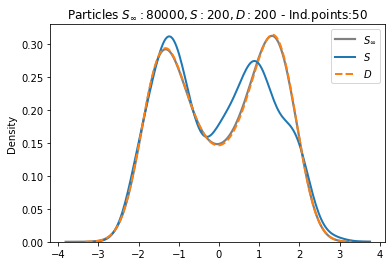

In [13]:
import warnings
warnings.filterwarnings('ignore')  ##this is here because the "distplot" is deprecated - TO DO: you know what you have to do
### justthe final density plot of the 3 systems
hist, bin_edge = np.histogram(Z[:,0],100,density=True);
import seaborn as sns
tss = 3999
sns.kdeplot()
sns.distplot(Z[:,tss],100,label=r'$S_{\infty}$',color="grey", hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.2});
sns.distplot(F[:,tss],100,label=r'$S$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.});
sns.distplot(M[:,tss],100,label=r'$D$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.,'linestyle':'--','alpha':0.5});
plt.legend(loc=1);
plt.title(r'Particles $S_{\infty}: %d, S: %d, D: %d$ - Ind.points:$%d$'%(Ninf,N,N,num_ind))
plt.savefig("histteliko.png", bbox_inches='tight')

In [14]:
##pickling the data so that we don't need to re run the simulation  every time we want to replot 
import pickle

Book = dict() #things to store
Book['M'] = M #
Book['F'] = F
Book['mean_Z'] = mean_Z
Book['std_Z'] = std_Z
Book['skew_Z'] = skew_Z
Book['kurt_Z'] = kurt_Z
Book['N'] = N
Book['Ninf'] = Ninf
Book['timegrid'] = timegrid
Book['h'] = h
Book['num_ind'] = num_ind 
Book['g'] = g
Book['x0'] = x0
Book['Z'] = Z
#pickle.dump( Book, open( "stored_double_well.dat", "wb" ) )   ### uncomment to pickle


In [15]:
"""
#uncomment to load
import pickle
Book = pickle.load(open( "stored_double_well.dat",  "rb" ) )
M = Book['M'] 
F = Book['F']
Z = Book['Z']
mean_Z = Book['mean_Z']
std_Z = Book['std_Z'] 
skew_Z = Book['skew_Z'] 
kurt_Z = Book['kurt_Z'] 
N = Book['N']
Ninf = Book['Ninf'] 
timegrid = Book['timegrid'] 
h = Book['h']
num_ind = Book['num_ind'] 
g = Book['g'] 
#Book['x0'] = x0
"""

'\n#uncomment to load\nimport pickle\nBook = pickle.load(open( "stored_double_well.dat",  "rb" ) )\nM = Book[\'M\'] \nF = Book[\'F\']\nZ = Book[\'Z\']\nmean_Z = Book[\'mean_Z\']\nstd_Z = Book[\'std_Z\'] \nskew_Z = Book[\'skew_Z\'] \nkurt_Z = Book[\'kurt_Z\'] \nN = Book[\'N\']\nNinf = Book[\'Ninf\'] \ntimegrid = Book[\'timegrid\'] \nh = Book[\'h\']\nnum_ind = Book[\'num_ind\'] \ng = Book[\'g\'] \n#Book[\'x0\'] = x0\n'

In [16]:
import seaborn as sns
purple_pal = sns.color_palette("flare", as_cmap=True)
endti = 4000
#potential ##for the background/ only for visualisation --- the drift f is the gradient of the potential
V=  lambda x: -2*x**2 + 0.5*x**4
#points on x axis to evaluate the potential
xis = np.linspace(-2.9,2.9,2000)
#one dimentional potential
Vs = V(xis)
Vs[Vs>10] = 10  ## upper limit for the value of the potential for better visualisation
#potential for every time point
Vtime = np.tile( Vs, (endti,1))




In [17]:
#figure and plotting settings
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 10*1.2
# plt.rcParams['font.family'] = 'sans-serif'     # not available in Colab
# plt.rcParams['font.sans-serif'] = 'Helvetica'  # not available in Colab
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 10*1.2
plt.rcParams['ytick.labelsize'] = 10*1.2
plt.rcParams['axes.labelsize'] = 12*1.2
plt.rcParams['axes.linewidth'] = 2
plt.rc('axes',edgecolor='#4f4949')
plt.rcParams['figure.frameon'] = False
plt.rcParams['figure.subplot.hspace'] = 0.05
plt.rcParams['figure.subplot.wspace'] = 0.05
plt.rcParams['figure.subplot.left'] = 0.4
plt.rcParams['figure.subplot.right'] = 0.5

In [18]:
##computing the transient mean and std
mean_M = np.mean(M,axis=0)
std_M = np.std(M,axis=0)

mean_F = np.mean(F,axis=0)
std_F = np.std(F,axis=0)



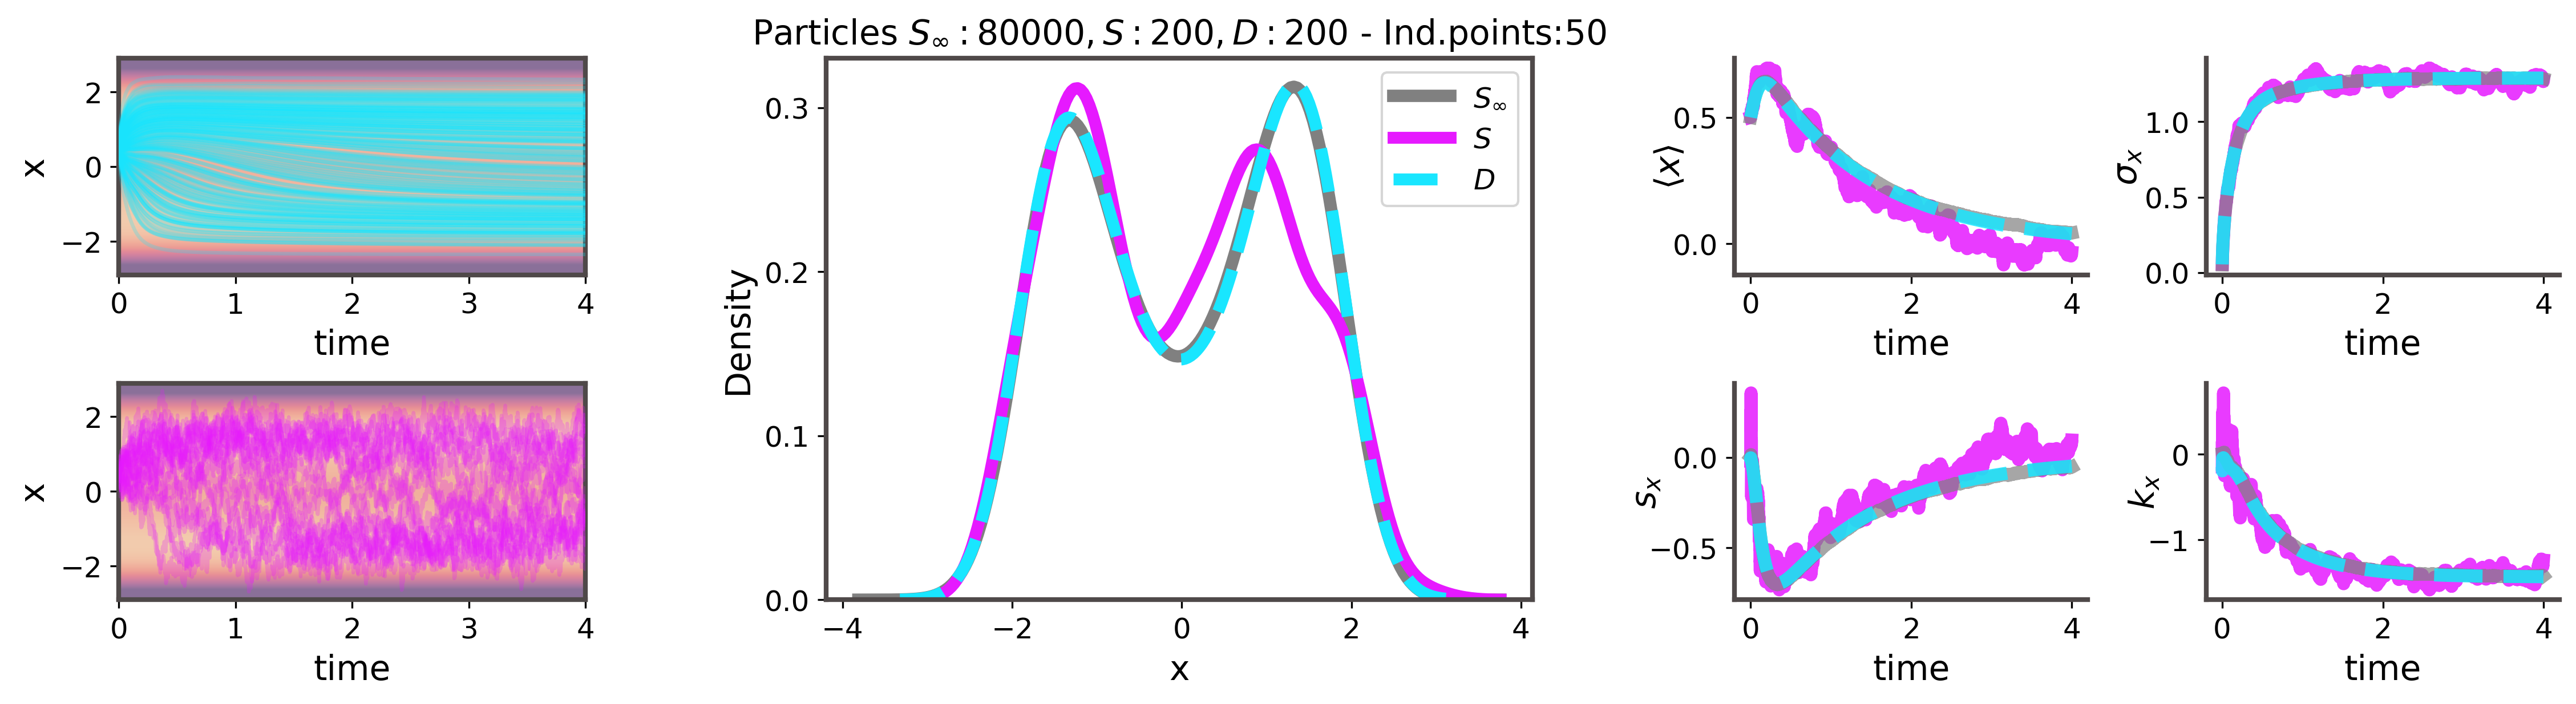

In [19]:
##this generates a signle plot

import matplotlib.gridspec as gridspec
labelkey = ['Sinf','S','D']
ds_palette = plt.get_cmap('cool')#sns.diverging_palette(145, 300, s=60, as_cmap=True)
my_mag = ds_palette(0.1)
my_green = ds_palette(0.9)
endti=3999
colors = ['grey', my_green,my_mag ]
fig4 = plt.figure(figsize=(15,4),constrained_layout=True)
widths = [1,1,1,1,1,1]
heights = [1,1]
spec4 = fig4.add_gridspec(ncols=6, nrows=2, width_ratios=widths,height_ratios=heights)
f4_ax = [None] *7
f4_ax[0] = fig4.add_subplot(spec4[0, :2])
f4_ax[0].imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
f4_ax[0].plot((M[::1,:endti]).T, color=colors[2],alpha=0.25,zorder=3);
f4_ax[0].set_xlabel('time');
f4_ax[0].set_ylabel('x');
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
f4_ax[0].set_xticks(t_positions);
f4_ax[0].set_xticklabels(t_labels)
f4_ax[0].set_aspect(320)

### plot 2
f4_ax[1] = fig4.add_subplot(spec4[1, :2])
f4_ax[1].imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
f4_ax[1].plot((F[::8,:endti]).T, color=colors[1],alpha=0.25,zorder=3);
f4_ax[1].set_xlabel('time');
f4_ax[1].set_ylabel('x');
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
f4_ax[1].set_xticks(t_positions);
f4_ax[1].set_xticklabels(t_labels)
f4_ax[1].set_aspect(320)

###plot 3
tss = 3999
f4_ax[2] = fig4.add_subplot(spec4[0:,2 :4])
sns.distplot(Z[:,tss],100,label=r'$S_{\infty}$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':5.2}, ax=f4_ax[2],color='grey');
sns.distplot(F[:,tss],100,label=r'$S$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':5.}, ax=f4_ax[2], color = colors[1]);
sns.distplot(M[:,tss],100,label=r'$D$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':5.,'linestyle':'--','alpha':0.5}, ax=f4_ax[2], color=colors[2]);
plt.legend(loc=1);
plt.title(r'Particles $S_{\infty}: %d, S: %d, D: %d$ - Ind.points:$%d$'%(Ninf,N,N,num_ind))
f4_ax[2].set_xlabel('x')
d_positions = [0,0.1,0.2,0.3]; # pixel count at label position
f4_ax[2].set_yticks(d_positions);

###### definitions


Fi = [[], F, M]
#colors = ['grey','magenta','green' ]
alphas = [0.7,0.85,0.85,0.5]
zorder = [2,1,3,3]
labelss=['x','y','z']
linestyles = ['-', '-', '--']
####plot4 
f4_ax[3] = fig4.add_subplot(spec4[0,4:5])
di=0
num_sys = len(Fi)  
for si in range(num_sys):
    if si==0:
      f4_ax[3].plot(timegrid, mean_Z,lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax[3].plot(timegrid, np.mean(Fi[si][:,:],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax[3].set_ylabel(r'$\langle %s \rangle $'%labelss[di], labelpad=-6)  
f4_ax[3].set_xlabel('time')
f4_ax[3].spines['right'].set_visible(False)
f4_ax[3].spines['top'].set_visible(False)
####plot5 
f4_ax[4] = fig4.add_subplot(spec4[0,5:6])
for si in range(num_sys):
    if si==0:
      f4_ax[4].plot(timegrid, std_Z,lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax[4].plot(timegrid, np.std(Fi[si][:,:],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax[4].set_ylabel(r'$ \sigma_{%s}$'%(labelss[di]), labelpad=0)  
f4_ax[4].set_xlabel('time')
f4_ax[4].spines['right'].set_visible(False)
f4_ax[4].spines['top'].set_visible(False)

####plot6 
f4_ax[5] = fig4.add_subplot(spec4[1,4:5])
for si in range(num_sys):
    if si==0:
      f4_ax[5].plot(timegrid, skew_Z,lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax[5].plot(timegrid, skew(Fi[si][:,:],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax[5].set_ylabel(r'$s_{%s} $'%(labelss[di]), labelpad=-6)  
f4_ax[5].set_xlabel('time')
f4_ax[5].spines['right'].set_visible(False)
f4_ax[5].spines['top'].set_visible(False)

####plot7 
f4_ax[6] = fig4.add_subplot(spec4[1,5:6])

for si in range(num_sys):
    if si==0:
      f4_ax[6].plot(timegrid, kurt_Z,lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax[6].plot(timegrid, kurtosis(Fi[si][:,:],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax[6].set_ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-6)  
f4_ax[6].set_xlabel('time')
f4_ax[6].spines['right'].set_visible(False)
f4_ax[6].spines['top'].set_visible(False)

#fig4.tight_layout()
plt.savefig("overall_second.png", bbox_inches='tight')

In [20]:
## get axon limits from full plot

ax_lim = dict()
for i in range(7):
  ax_lim[i] = [ f4_ax[i].get_xlim() ,f4_ax[i].get_ylim() ]


  

In [21]:
plt.ioff()

In [26]:
!mkdir imag ## create folder to store the plots
###here I create the series of images that later combine with ffmpeg to create the animation
### since the Ninfty system has large memory requirements it is preferable to store the images one by one
import warnings
warnings.filterwarnings('ignore')
labelkey = ['Sinf','S','D']
#for ti in range(0,4000,1):
for ti in range(0,4000,500): ##chabge the step here to change the number of intermediate plots to be generated
  fig5 = plt.figure(figsize=(15,4),constrained_layout=True)
  widths = [1,1,1,1,1,1]
  heights = [1,1]
  spec4 = fig5.add_gridspec(ncols=6, nrows=2, width_ratios=widths,height_ratios=heights)
  f5_ax = [None] *7
  f5_ax[0] = fig5.add_subplot(spec4[0, :2])
  f5_ax[0].imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.85, extent=[0, endti, -2.9, 2.9]);
  f5_ax[0].plot((M[::1,:ti]).T, color=colors[2],alpha=0.25,zorder=3);
  f5_ax[0].plot([ti]*200,(M[::1,ti]), '.',color=colors[2],alpha=0.55,zorder=4, markersize=3);
  f5_ax[0].set_xlabel('time');
  f5_ax[0].set_ylabel('x');
  t_positions = [0,999,1999,2999,3999]; # pixel count at label position
  t_labels = [0,1,2,3,4];# labels you want to see
  f5_ax[0].set_xticks(t_positions);
  f5_ax[0].set_xticklabels(t_labels)
  f5_ax[0].set_aspect(320)

  ### plot 2
  f5_ax[1] = fig5.add_subplot(spec4[1, :2])
  f5_ax[1].imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.85, extent=[0, endti, -2.9, 2.9]);
  f5_ax[1].plot((F[::4,:ti]).T, color=colors[1],alpha=0.25,zorder=3);
  f5_ax[1].plot([ti]*50,(F[::4,ti]), '.',color=colors[1],alpha=0.85,zorder=4, markersize=3);
  f5_ax[1].set_xlabel('time');
  f5_ax[1].set_ylabel('x');
  t_positions = [0,999,1999,2999,3999]; # pixel count at label position
  t_labels = [0,1,2,3,4];# labels you want to see
  f5_ax[1].set_xticks(t_positions);
  f5_ax[1].set_xticklabels(t_labels)
  f5_ax[1].set_aspect(320)

  ###plot 3
  
  f5_ax[2] = fig5.add_subplot(spec4[0:,2 :4])
  sns.distplot(Z[:,ti],100,label=r'$S_{\infty}$', hist=False,kde_kws={'cumulative':False,'bw_method':lambda x:0.25,'lw':5.2}, ax=f5_ax[2],color='grey');
  sns.distplot(F[:,ti],100,label=r'$S$', hist=False,kde_kws={'cumulative':False,'bw_method':lambda x:0.25,'lw':5.}, ax=f5_ax[2], color = colors[1]);
  sns.distplot(M[:,ti],100,label=r'$D$', hist=False,kde_kws={'cumulative':False,'bw_method':lambda x:0.25,'lw':5.,'linestyle':'--','alpha':0.5}, ax=f5_ax[2], color=colors[2]);
  plt.legend(loc=1);
  plt.title(r'Particles $S_{\infty}: %d, S: %d, D: %d$ - Ind.points:$%d$'%(Ninf,N,N,num_ind))
  f5_ax[2].set_xlabel('x')
  d_positions = [0,0.1,0.5,1]; # pixel count at label position
  #f5_ax[2].set_yticks(d_positions);
  f5_ax[2].set_xlim(ax_lim[2][0])
  #f5_ax[2].set_ylim(0,5)
  ###### definitions


  Fi = [[], F, M]
  #colors = ['grey','magenta','green' ]
  alphas = [0.7,0.85,0.85,0.5]
  zorder = [2,1,3,3]
  labelss=['x','y','z']
  linestyles = ['-', '-', '--']
  ####plot4 
  f5_ax[3] = fig5.add_subplot(spec4[0,4:5])
  di=0
  num_sys = len(Fi)  
  for si in range(num_sys):
      if si==0:
        f5_ax[3].plot(timegrid[:ti], mean_Z[:ti],lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:      
          f5_ax[3].plot(timegrid[:ti], np.mean(Fi[si][:,:ti],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
  f5_ax[3].set_ylabel(r'$\langle %s \rangle $'%labelss[di], labelpad=-6)  
  f5_ax[3].set_xlabel('time')
  f5_ax[3].spines['right'].set_visible(False)
  f5_ax[3].spines['top'].set_visible(False)
  f5_ax[3].set_ylim(ax_lim[3][1])
  f5_ax[3].set_xlim(ax_lim[3][0])
  ####plot5 
  f5_ax[4] = fig5.add_subplot(spec4[0,5:6])
  for si in range(num_sys):
      if si==0:
        f5_ax[4].plot(timegrid[:ti], std_Z[:ti],lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:      
          f5_ax[4].plot(timegrid[:ti], np.std(Fi[si][:,:ti],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
  f5_ax[4].set_ylabel(r'$ \sigma_{%s}$'%(labelss[di]), labelpad=0)  
  f5_ax[4].set_xlabel('time')
  f5_ax[4].spines['right'].set_visible(False)
  f5_ax[4].spines['top'].set_visible(False)
  f5_ax[4].set_xlim(ax_lim[4][0])
  f5_ax[4].set_ylim(ax_lim[4][1])

  ####plot6 
  f5_ax[5] = fig5.add_subplot(spec4[1,4:5])
  for si in range(num_sys):
      if si==0:
        f5_ax[5].plot(timegrid[:ti], skew_Z[:ti],lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else: 
          if ti>0:     
            f5_ax[5].plot(timegrid[:ti], skew(Fi[si][:,:ti],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
  f5_ax[5].set_ylabel(r'$s_{%s} $'%(labelss[di]), labelpad=-6)  
  f5_ax[5].set_xlabel('time')
  f5_ax[5].spines['right'].set_visible(False)
  f5_ax[5].spines['top'].set_visible(False)
  f5_ax[5].set_xlim(ax_lim[5][0])
  f5_ax[5].set_ylim(ax_lim[5][1])

  ####plot7 
  f5_ax[6] = fig5.add_subplot(spec4[1,5:6])

  for si in range(num_sys):
      if si==0:
        f5_ax[6].plot(timegrid[:ti], kurt_Z[:ti],lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:   
          if ti>0:   
            f5_ax[6].plot(timegrid[:ti], kurtosis(Fi[si][:,:ti],axis=0),lw=5.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
  f5_ax[6].set_ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-6)  
  f5_ax[6].set_xlabel('time')
  f5_ax[6].spines['right'].set_visible(False)
  f5_ax[6].spines['top'].set_visible(False)
  f5_ax[6].set_xlim(ax_lim[6][0])
  f5_ax[6].set_ylim(ax_lim[6][1])

  #fig4.tight_layout()
  #plt.show();
  
  plt.savefig("imag/%06d.png"%(ti+1), bbox_inches='tight')
  plt.close();  ### I do not show here the plots only store and close to avoid filling the RAM - if you want to plot them here uncomment the plt.show() above

In [ ]:
#@title zip and download from colab
!zip -r imag.zip imag
from google.colab import files
files.download("imag.zip")
#import shutil

#shutil.rmtree('imag', ignore_errors=True)

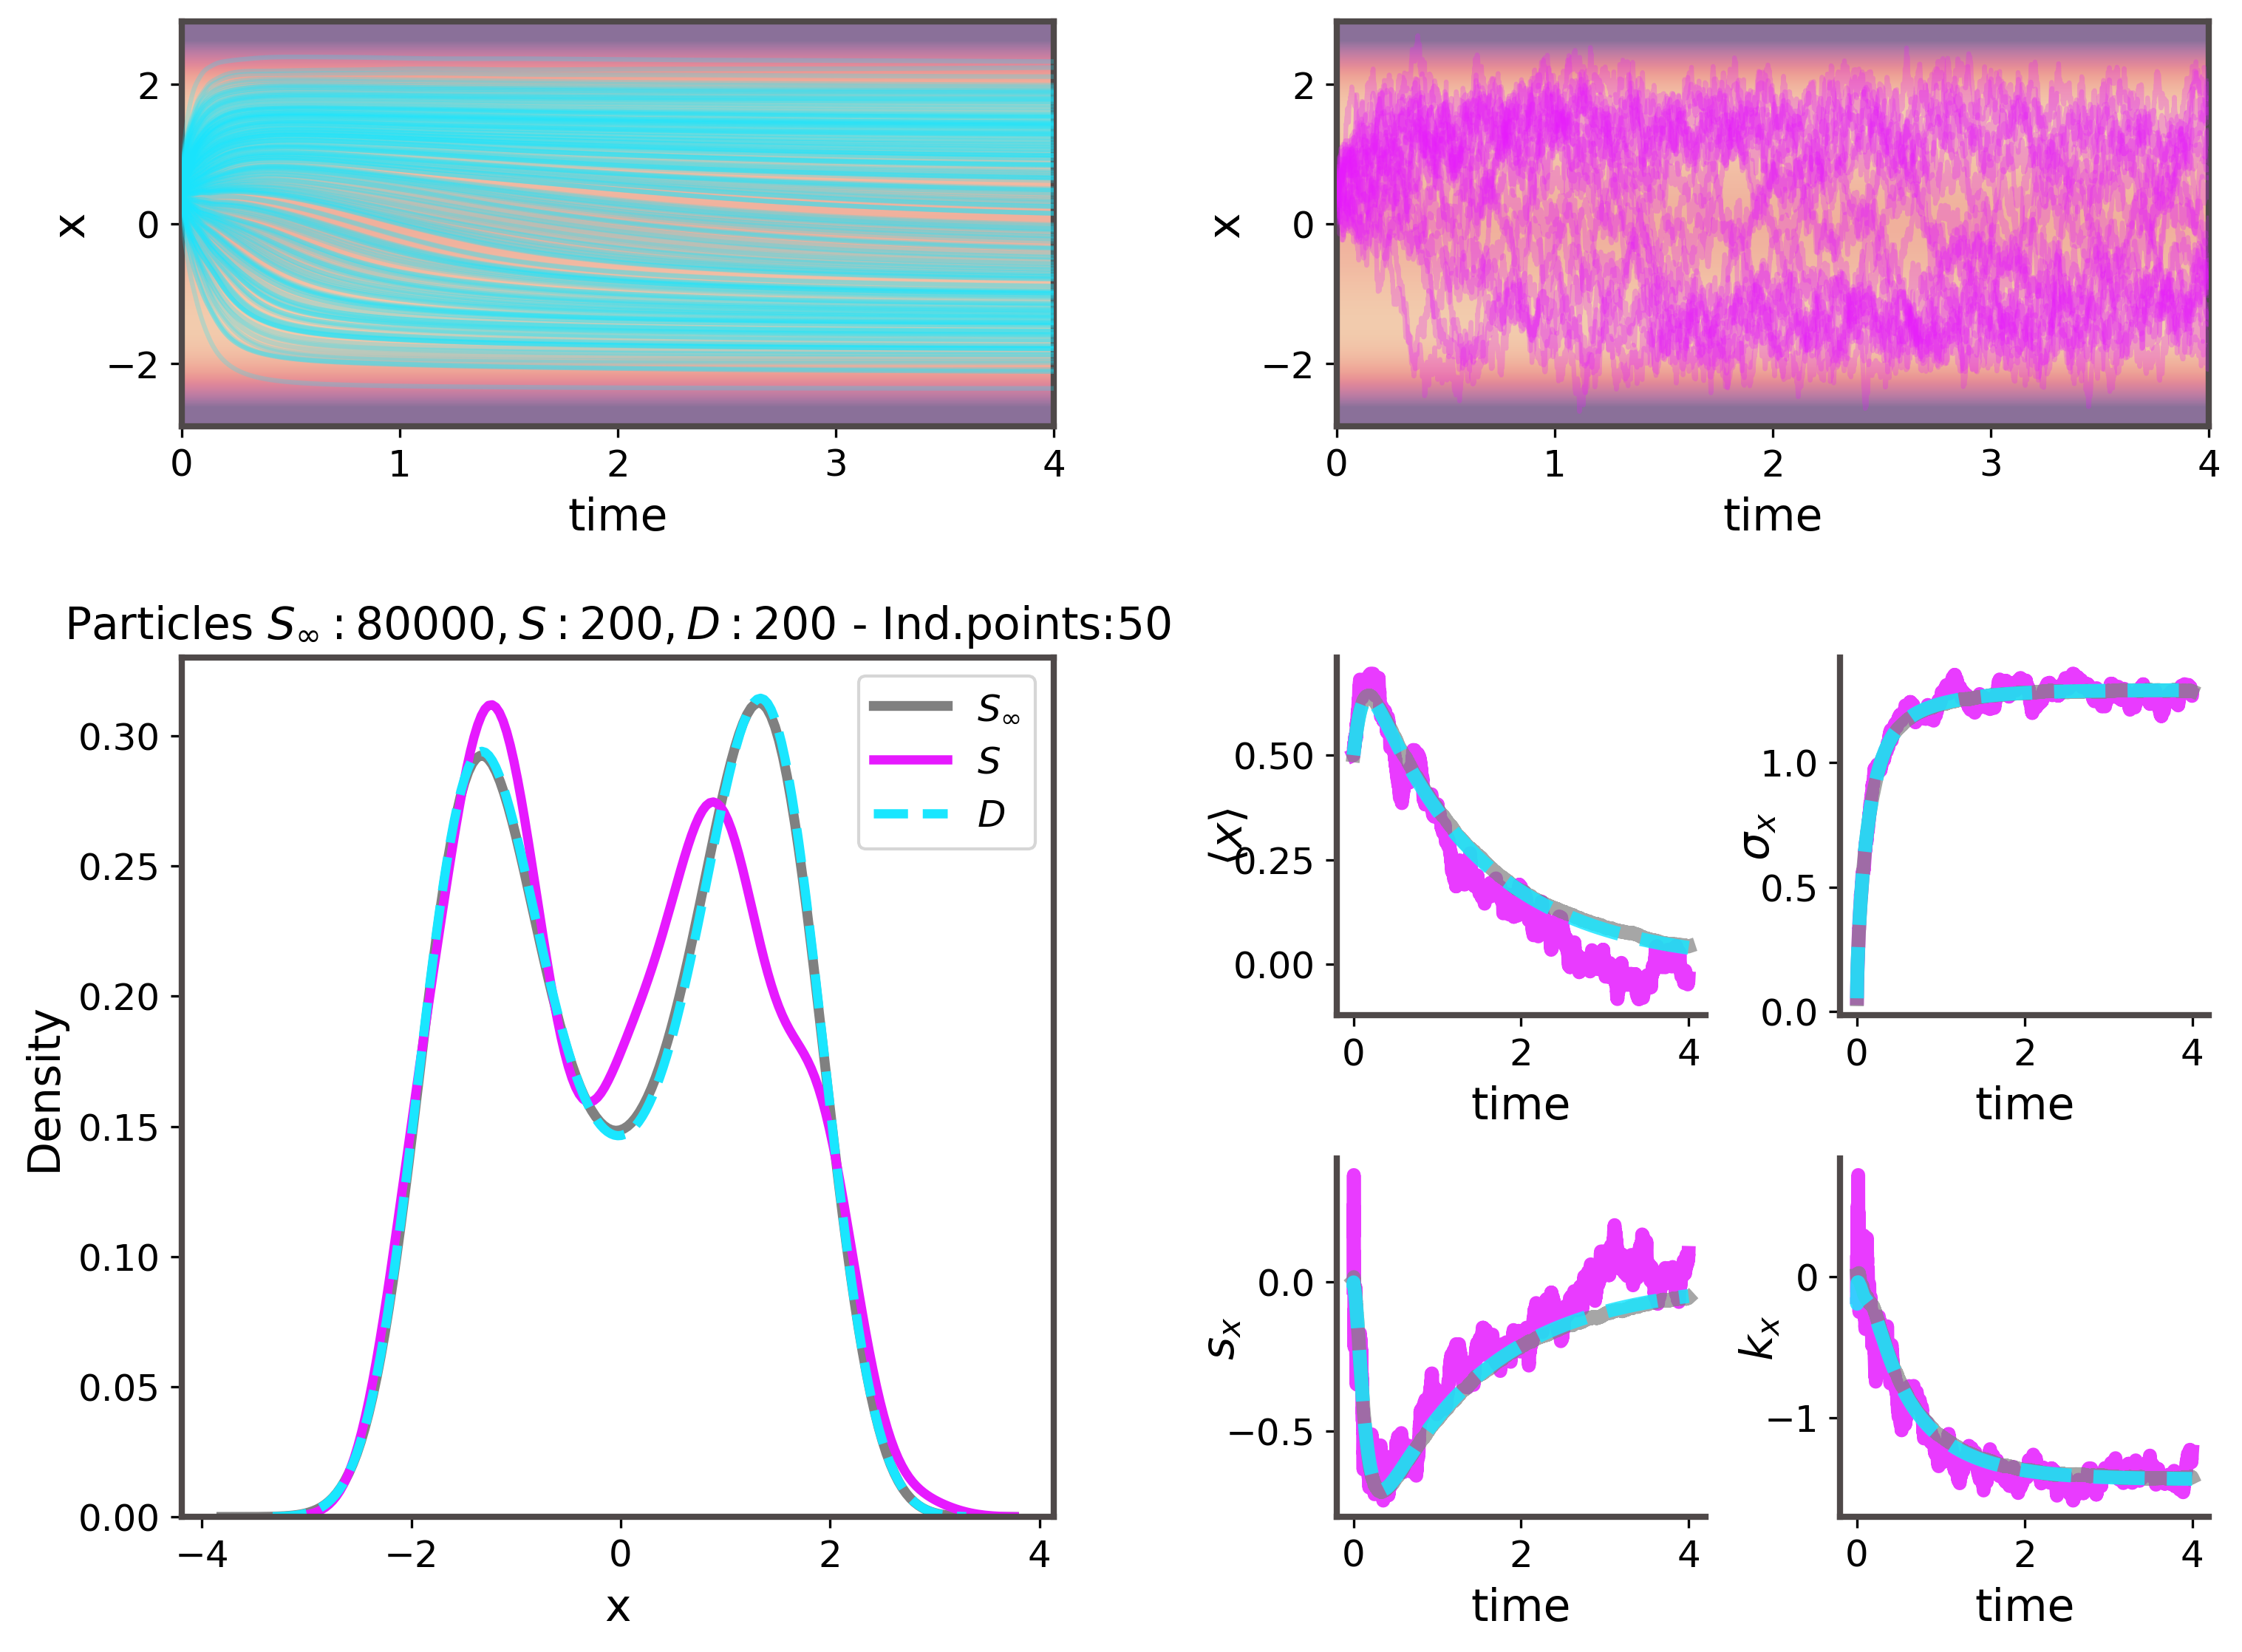

In [27]:
#@title different subplot arangement

import matplotlib.gridspec as gridspec
labelkey = ['Sinf','S','D']
Fi = [[], F, M]
ds_palette = plt.get_cmap('cool')#sns.diverging_palette(145, 300, s=60, as_cmap=True)
my_mag = ds_palette(0.1)
my_green = ds_palette(0.9)
endti=3999
colors = ['grey', my_green,my_mag ]
fig4 = plt.figure(figsize=(10,8),constrained_layout=True)
widths = [1,1,1,1]
heights = [1,0.5,0.5]
spec4 = fig4.add_gridspec(ncols=4, nrows=3, width_ratios=widths,height_ratios=heights)

f4_ax1 = fig4.add_subplot(spec4[0, :2])
f4_ax1.imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
f4_ax1.plot((M[::1,:endti]).T, color=colors[2],alpha=0.25,zorder=3);
f4_ax1.set_xlabel('time');
f4_ax1.set_ylabel('x');
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
f4_ax1.set_xticks(t_positions);
f4_ax1.set_xticklabels(t_labels)
f4_ax1.set_aspect(320)

### plot 2
f4_ax2 = fig4.add_subplot(spec4[0,2 :])
f4_ax2.imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
f4_ax2.plot((F[::8,:endti]).T, color=colors[1],alpha=0.25,zorder=3);
f4_ax2.set_xlabel('time');
f4_ax2.set_ylabel('x');
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
f4_ax2.set_xticks(t_positions);
f4_ax2.set_xticklabels(t_labels)
f4_ax2.set_aspect(320)

###plot 3
tss = 3999
f4_ax3 = fig4.add_subplot(spec4[1:,0 :2])
sns.distplot(Z[:,tss],100,label=r'$S_{\infty}$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':3.2}, ax=f4_ax3,color='grey');
sns.distplot(F[:,tss],100,label=r'$S$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':3.}, ax=f4_ax3, color = colors[1]);
sns.distplot(M[:,tss],100,label=r'$D$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':3.,'linestyle':'--','alpha':0.5}, ax=f4_ax3, color=colors[2]);
plt.legend(loc=1);
plt.title(r'Particles $S_{\infty}: %d, S: %d, D: %d$ - Ind.points:$%d$'%(Ninf,N,N,num_ind))
f4_ax3.set_xlabel('x')

###### definitions


Fi = [[], F, M]
#colors = ['grey','magenta','green' ]
alphas = [0.7,0.85,0.85,0.5]
zorder = [2,1,3,3]
labelss=['x','y','z']
linestyles = ['-', '-', '--']
####plot4 
f4_ax4 = fig4.add_subplot(spec4[1,2:3])
di=0
num_sys = len(Fi)  
for si in range(num_sys):
    if si==0:
      f4_ax4.plot(timegrid, mean_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax4.plot(timegrid, np.mean(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax4.set_ylabel(r'$\langle %s \rangle $'%labelss[di], labelpad=-6)  
f4_ax4.set_xlabel('time')
f4_ax4.spines['right'].set_visible(False)
f4_ax4.spines['top'].set_visible(False)
####plot5 
f4_ax5 = fig4.add_subplot(spec4[1,3:4])
for si in range(num_sys):
    if si==0:
      f4_ax5.plot(timegrid, std_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax5.plot(timegrid, np.std(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax5.set_ylabel(r'$ \sigma_{%s}$'%(labelss[di]), labelpad=-6)  
f4_ax5.set_xlabel('time')
f4_ax5.spines['right'].set_visible(False)
f4_ax5.spines['top'].set_visible(False)

####plot6 
f4_ax6 = fig4.add_subplot(spec4[2,2:3])
for si in range(num_sys):
    if si==0:
      f4_ax6.plot(timegrid, skew_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax6.plot(timegrid, skew(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax6.set_ylabel(r'$s_{%s} $'%(labelss[di]), labelpad=-6)  
f4_ax6.set_xlabel('time')
f4_ax6.spines['right'].set_visible(False)
f4_ax6.spines['top'].set_visible(False)

####plot7 
f4_ax7 = fig4.add_subplot(spec4[2,3:4])

for si in range(num_sys):
    if si==0:
      f4_ax7.plot(timegrid, kurt_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
    else:      
        f4_ax7.plot(timegrid, kurtosis(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si], linestyle=linestyles[si])
f4_ax7.set_ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-6)  
f4_ax7.set_xlabel('time')
f4_ax7.spines['right'].set_visible(False)
f4_ax7.spines['top'].set_visible(False)

#fig4.tight_layout()
plt.savefig("overall_second.png", bbox_inches='tight')

In [ ]:
#@title 
plt.figure(figsize=(12,16))
#plt.figure()
plt.subplot(2,2,1)
plt.imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
#x_positions = [0,999,1999]; # pixel count at label position
#x_labels = [-0.8,0,0.8];# labels you want to see
#plt.yticks(x_positions, x_labels);
#t_positions = [0,999,1999,2999,3999,4999]; # pixel count at label position
#t_labels = [0,1,2,3,4,5];# labels you want to see
#plt.xticks(t_positions, t_labels);
#plt.colorbar(cbar_size="15%", cbar_pad="5%")

#plt.plot(mean_M[:endti],'maroon', lw=2)
#plt.plot(mean_M[:endti]+std_M[:endti],'maroon', lw=2)
#plt.plot(mean_M[:endti]-std_M[:endti],'maroon', lw=2)
plt.plot((M[::1,:endti]).T, 'gray',alpha=0.25,zorder=3);
plt.xlabel('time');
plt.ylabel('x');
#plt.plot(mean_M_l[:1000],'cadetblue', lw=2)
#plt.plot(mean_M_l[:1000]+std_M_l[:1000],'cadetblue', lw=2)
#plt.plot(mean_M_l[:1000]-std_M_l[:1000],'cadetblue', lw=2)
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
plt.xticks(t_positions, t_labels);
ax1 = plt.gca()
ax1.set_aspect(320)

plt.subplot(2,2,2)
plt.imshow(Vtime.T, origin='lower',interpolation='nearest',cmap=purple_pal,alpha=0.65, extent=[0, endti, -2.9, 2.9]);
#x_positions = [0,999,1999]; # pixel count at label position
#x_labels = [-0.8,0,0.8];# labels you want to see
#plt.yticks(x_positions, x_labels);
#
plt.plot((F[::8,:endti]).T, 'gray',alpha=0.25,zorder=3);
#plt.plot(mean_F[:endti],'maroon', lw=2)
#plt.plot(mean_F[:endti]+std_F[:endti],'maroon', lw=2)
#plt.plot(mean_F[:endti]-std_F[:endti],'maroon', lw=2)
plt.xlabel('time');
t_positions = [0,999,1999,2999,3999]; # pixel count at label position
t_labels = [0,1,2,3,4];# labels you want to see
plt.xticks(t_positions, t_labels);
ax2 = plt.gca()
ax2.set_aspect(320)

plt.subplot(2,2,3)
tss = 3999

sns.distplot(Z[:,tss],100,label=r'$S_{\infty}$',color="grey", hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.2});
sns.distplot(F[:,tss],100,label=r'$S$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.});
sns.distplot(M[:,tss],100,label=r'$D$', hist=False,kde_kws={'cumulative':False,'bw':0.25,'lw':2.,'linestyle':'--','alpha':0.5});
plt.legend(loc=1);
plt.title(r'Particles $S_{\infty}: %d, S: %d, D: %d$ - Ind.points:$%d$'%(Ninf,N,N,num_ind))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
#plt.savefig("histteliko.png", bbox_inches='tight')


In [ ]:
#@title 
from scipy.stats import skew, kurtosis 

labelkey = ['Sinf','S','D']
Fi = [[], F, M]
import seaborn as sns
ds_palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
my_mag = ds_palette[-1]
my_green = ds_palette[0]
colors = ['grey', my_green,my_mag ]
alphas = [0.7,0.85,0.85,0.5]
zorder = [2,1,3,3]
labelss=['x','y','z']
fig_width_pt = 546.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
fig1=plt.figure(figsize=fig_size)
plt.rc('axes',edgecolor='#0a0a0a')
dim=1
num_sys = len(Fi)
for di in range(dim):
  plt.subplot(dim,4,di*4+1)
  
  for si in range(num_sys):
      if si==0:
        plt.plot(timegrid, mean_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:
        if dim>1:
            plt.plot(timegrid, np.mean(Fi[si][di,:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=(si+1)**2,alpha=alphas[si])
        else:
            plt.plot(timegrid, np.mean(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      
          
  #plt.ylim( [None,0.1])
  #plt.ylabel(u'mean_x_%d'%di) 
  if di==2:
      plt.ylabel(r'$\langle %s \rangle $'%labelss[di], labelpad=5)
  else:            
      plt.ylabel(r'$\langle %s \rangle $'%labelss[di])          
  if di==0:
      ### this line for 2D OU
      plt.legend(loc=9, bbox_to_anchor=(0.8,1.35),frameon=True,shadow=None,framealpha =1,edgecolor ='#0a0a0a')
      #plt.legend(loc=9, bbox_to_anchor=(0.8,1.65),frameon=True,shadow=None,framealpha =1,edgecolor ='#0a0a0a')
      #plt.gca().set_title('mean', fontsize=14)
  if di==dim-1:
      plt.xlabel('time')
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)
      

  plt.subplot(dim,4,di*4+2)
  
  for si in range(num_sys):
      if si==0:
        plt.plot(timegrid, std_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:
        if dim>1:
            plt.plot(timegrid, np.std(Fi[si][di,:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=(si+1)**2,alpha=alphas[si])
        else:
            plt.plot(timegrid, np.std(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      
          
  #plt.plot(timegrid, np.std(G[di,:,:],axis=0),lw=2.5,label='D',color=col_ro)        
  plt.ylabel(r'$ \sigma_{%s}$'%(labelss[di]))          
#        if di==0:            
#            plt.gca().set_title('std', fontsize=14)
  if di==dim-1:
      plt.xlabel('time')
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)  

  plt.subplot(dim,4,di*4+3)
  
  for si in range(num_sys):
      if si==0:
        plt.plot(timegrid, skew_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:
        if dim> 1:
            plt.plot(timegrid, skew(Fi[si][di,:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=(si+1)**2,alpha=alphas[si])
        else:
            plt.plot(timegrid, skew(Fi[si],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      
          
  #plt.plot(timegrid, skew(G[di,:,:],axis=0),lw=2.5,label='D',color=col_ro)        
  #plt.ylabel(r'$s_{%s} $'%(labelss[di]), labelpad=-14)   #for 2D OU ###################
  plt.ylabel(r'$s_{%s} $'%(labelss[di]), labelpad=-6)
#        if di==0:            
#            plt.gca().set_title('skewness', fontsize=14)
  if di==dim-1:
      plt.xlabel('time')
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)  

  plt.subplot(dim,4,di*4+4)
  
  for si in range(num_sys):
      if si==0:
        plt.plot(timegrid, kurt_Z,lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
      else:
        if dim> 1:
            plt.plot(timegrid, kurtosis(Fi[si][di,:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=(si+1)**2,alpha=alphas[si])
        else:
            plt.plot(timegrid, kurtosis(Fi[si][:,:],axis=0),lw=4.5,label=labelkey[si],color=colors[si],zorder=zorder[si],alpha=alphas[si])
                      
  
  #plt.plot(timegrid, kurtosis(G[di,:,:],axis=0),lw=2.5,label='D',color=col_ro)        
  if di==0:
      plt.ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-14) 
  elif di==2:
      plt.ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-5) 
  else:
      plt.ylabel(r'$k_{%s}  $'%(labelss[di]), labelpad=-14) 
#        if di==0:            
#            plt.gca().set_title('kurtosis', fontsize=14)
  if di==dim-1:
      plt.xlabel('time')
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)   

plt.subplots_adjust( wspace=0.98, hspace=0.2,bottom=0.15)

